In [79]:
from Bio import SeqIO
import pandas as pd
import pyBigWig
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn
import torch
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


In [80]:
output_file = "dataset.npz"

In [81]:
if not os.path.exists(output_file):
    genome_file = "GRCh38.primary_assembly.genome.fa"
    genome = SeqIO.to_dict(SeqIO.parse(genome_file, "fasta"))
    print("Chromosomes loaded:", list(genome.keys())[:5])

Chromosomes loaded: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']


In [82]:
if not os.path.exists(output_file):
    gtf_file = "gencode.v49.primary_assembly.basic.annotation.gtf"
    genes = []

    with open(gtf_file) as f:
        for line in f:
            if line.startswith("#"): continue
            fields = line.strip().split("\t")
            if fields[2] != "gene": continue
            chrom = fields[0]
            start = int(fields[3])
            end = int(fields[4])
            strand = fields[6]
            # Parse gene_id from attributes
            attr = fields[8]
            gene_id = attr.split('gene_id "')[1].split('"')[0]
            genes.append([gene_id, chrom, start, end, strand])

    genes_df = pd.DataFrame(genes, columns=["gene_id","chrom","start","end","strand"])
    print("Number of genes:", len(genes_df))
    genes_df.head()

Number of genes: 78899


In [83]:
if not os.path.exists(output_file):
    plus_bw = pyBigWig.open("K562_plus_unique.bigWig")
    minus_bw = pyBigWig.open("K562_minus_unique.bigWig")

In [84]:
if not os.path.exists(output_file):
    print(list(genome.keys())[:5])
    print(list(plus_bw.chroms().keys())[:5])

['chr1', 'chr2', 'chr3', 'chr4', 'chr5']
['chr1', 'chr2', 'chr3', 'chr4', 'chr5']


In [85]:

def one_hot(seq):
    mapping = np.zeros(128, dtype=np.int8)  # ASCII table
    mapping[ord('A')] = 0
    mapping[ord('C')] = 1
    mapping[ord('G')] = 2
    mapping[ord('T')] = 3
    
    seq = seq.upper()
    arr = np.zeros((len(seq),4), dtype=np.float32)
    # only convert A/C/G/T
    valid_idx = np.array([ord(b) for b in seq])
    arr[np.arange(len(seq)), mapping[valid_idx]] = 1
    return arr

In [101]:

window = 7000
seq_len = 2 * window
subset_size = 35000
bin_size = 128  
num_bins = seq_len // bin_size

In [102]:

if os.path.exists(output_file):
    print("dataset.npz already exists. Skipping generation.")
else:
    print("Generating gene dataset...")

    # Filter valid chromosomes
    primary_genes_df = genes_df[
        genes_df['chrom'].isin(plus_bw.chroms().keys())
    ].reset_index(drop=True)

    primary_genes_df = primary_genes_df.iloc[:subset_size]
    genes = primary_genes_df.to_dict('records')

    print(f"Using {len(genes)} genes")

    # Integer encoding (compact)
    def int_encode(seq):
        mapping = {'A':0, 'C':1, 'G':2, 'T':3}
        return np.array([mapping.get(b, 4) for b in seq.upper()], dtype=np.int16)

    X = []
    y = []


    for row in genes:
        chrom = row['chrom']
        strand = row['strand']
        tss = row['start'] if strand == '+' else row['end']

        chrom_len = plus_bw.chroms()[chrom]
        seq_start = max(0, tss - window)
        seq_end = min(chrom_len, tss + window)

        seq = genome[chrom].seq[seq_start:seq_end]
        if strand == '-':
            seq = seq.reverse_complement()

        # Encode sequence
        seq_array = int_encode(str(seq))

        if len(seq_array) < seq_len:
            seq_array = np.pad(
                seq_array,
                (0, seq_len - len(seq_array)),
                mode='constant',
                constant_values=4
            )

        X.append(seq_array)

        # CAGE signal
        plus_signal = np.nan_to_num(
            plus_bw.values(chrom, seq_start, seq_end, numpy=True)
        )
        minus_signal = np.nan_to_num(
            minus_bw.values(chrom, seq_start, seq_end, numpy=True)
        )

        total_signal = plus_signal + minus_signal

        if len(total_signal) < seq_len:
            total_signal = np.pad(
                total_signal,
                (0, seq_len - len(total_signal)),
                mode='constant'
            )

        binned_signal = []

        for i in range(num_bins):
            start = i * bin_size
            end = start + bin_size
            binned_signal.append(total_signal[start:end].sum())

        y.append(np.array(binned_signal, dtype=np.float32))
        
    # Convert once at end
    X = np.array(X, dtype=np.int16)
    y = np.array(y, dtype=np.float32)

    np.savez_compressed(output_file, X=X, y=y)

    print("Saved dataset.npz")
    print("X shape:", X.shape)
    print("y shape:", y.shape)

Generating gene dataset...
Using 35000 genes
Saved dataset.npz
X shape: (35000, 14000)
y shape: (35000, 109)


In [104]:
class GeneDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path)
        self.X = data["X"]              # (35000, 14000)
        self.y = data["y"]              # (35000, 109), already float32

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.float32)  # shape (109,)
        return x, y
    
dataset = GeneDataset("dataset.npz")
print("Total samples:", len(dataset))
print("Sample y shape:", dataset[0][1].shape)  # should be (num_bins,)

Total samples: 35000
Sample y shape: torch.Size([109])


In [105]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size]
)


In [106]:
batch_size = 16  # adjust based on GPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

In [107]:


# ---------------------------
# Attention Pool
# ---------------------------
class AttentionPool(nn.Module):
    def __init__(self, pool_size, channels):
        super().__init__()
        self.pool_size = pool_size
        self.weight_proj = nn.Conv1d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, L = x.shape
        assert L % self.pool_size == 0

        weights = self.weight_proj(x)

        x = x.view(B, C, L // self.pool_size, self.pool_size)
        weights = weights.view(B, C, L // self.pool_size, self.pool_size)

        weights = torch.softmax(weights, dim=-1)
        return (x * weights).sum(dim=-1)


# ---------------------------
# Conv Blocks
# ---------------------------
class ResidualConvBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(channels),
            nn.GELU(),
            nn.Conv1d(channels, channels, kernel_size=1)
        )

    def forward(self, x):
        return x + self.block(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.GELU(),
            nn.Conv1d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2
            )
        )

    def forward(self, x):
        return self.block(x)


class ConvTowerBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.res = ResidualConvBlock(out_channels)
        self.pool = AttentionPool(pool_size=2, channels=out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.res(x)
        x = self.pool(x)
        return x


# ---------------------------
# Relative Position Encoding
# ---------------------------
class RelativePosition(nn.Module):
    def __init__(self, num_units, max_relative_position):
        super().__init__()
        self.max_relative_position = max_relative_position
        self.embeddings = nn.Parameter(
            torch.randn(2 * max_relative_position + 1, num_units)
        )

    def forward(self, length, device):
        positions = torch.arange(length, device=device)
        distances = positions[None, :] - positions[:, None]
        distances = torch.clamp(
            distances,
            -self.max_relative_position,
            self.max_relative_position
        )
        distances += self.max_relative_position
        return self.embeddings[distances]


# ---------------------------
# Multihead Attention with Relative Bias
# ---------------------------
class MultiHeadAttentionRel(nn.Module):
    def __init__(self, d_model, num_heads=8, key_size=32):
        super().__init__()

        self.num_heads = num_heads
        self.key_size = key_size
        self.inner_dim = num_heads * key_size

        self.q_proj = nn.Linear(d_model, self.inner_dim)
        self.k_proj = nn.Linear(d_model, self.inner_dim)
        self.v_proj = nn.Linear(d_model, self.inner_dim)
        self.out_proj = nn.Linear(self.inner_dim, d_model)

        self.rel_pos = RelativePosition(key_size, max_relative_position=256)

    def forward(self, x):
        B, L, C = x.shape

        q = self.q_proj(x).view(B, L, self.num_heads, self.key_size).transpose(1, 2)
        k = self.k_proj(x).view(B, L, self.num_heads, self.key_size).transpose(1, 2)
        v = self.v_proj(x).view(B, L, self.num_heads, self.key_size).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.key_size ** 0.5)

        rel_pos = self.rel_pos(L, x.device)
        rel_scores = torch.einsum('bhld,lmd->bhlm', q, rel_pos)
        scores = scores + rel_scores / (self.key_size ** 0.5)

        attn = torch.softmax(scores, dim=-1)

        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, L, self.inner_dim)

        return self.out_proj(out)


# ---------------------------
# Transformer Block (PreNorm)
# ---------------------------
class TransformerBlock(nn.Module):
    def __init__(self, d_model=128, num_heads=8, key_size=32, ff_hidden=256):
        super().__init__()

        self.norm1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttentionRel(d_model, num_heads, key_size)

        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden),
            nn.GELU(),
            nn.Linear(ff_hidden, d_model)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x


# ---------------------------
# Enformer Mini Scalar
# ---------------------------
class EnformerMiniScalar(nn.Module):
    def __init__(self, embed_dim=16):
        super().__init__()

        # Embedding
        self.embedding = nn.Embedding(5, embed_dim)

        # Stem
        self.stem = nn.Sequential(
            nn.Conv1d(embed_dim, 64, kernel_size=15, padding=7),
            nn.GELU(),
            ResidualConvBlock(64),
            AttentionPool(pool_size=2, channels=64)
        )

        # Conv tower
        tower_channels = [64, 96, 128]
        self.conv_tower = nn.Sequential(*[
            ConvTowerBlock(tower_channels[i], tower_channels[i+1])
            for i in range(len(tower_channels) - 1)
        ])

        # Transformer (4 layers like mini version)
        self.transformers = nn.Sequential(*[
            TransformerBlock(d_model=128)
            for _ in range(4)
        ])

        # Pointwise
        self.pointwise = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=1),
            nn.Dropout(0.05),
            nn.GELU()
        )

        # Output head
        self.output_head = nn.Sequential(
            nn.Conv1d(256, 1, kernel_size=1),
            nn.Softplus()
        )

    def forward(self, x):
        # x: (B, seq_len)

        x = self.embedding(x)      # (B, L, embed_dim)
        x = x.transpose(1, 2)      # (B, embed_dim, L)

        x = self.stem(x)
        x = self.conv_tower(x)

        x = x.transpose(1, 2)
        x = self.transformers(x)
        x = x.transpose(1, 2)

        x = self.pointwise(x)
        self.output_head = nn.Sequential(
            nn.Conv1d(256, num_bins, kernel_size=1),  # output one value per bin
            nn.Softplus()
        )
        x = x.squeeze(1)

        return x

In [66]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Device set to: Apple MPS (GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Device set to: NVIDIA CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("Device set to: CPU")


Device set to: Apple MPS (GPU)


In [67]:
model = EnformerMiniScalar().to(device)
loss_fn = nn.PoissonNLLLoss(log_input=False, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:

num_epochs = 20
best_val_corr = -float('inf')

train_losses = []
val_losses = []
train_corrs = []
val_corrs = []

patience = 5
epochs_without_improvement = 0

for epoch in range(num_epochs):
    # ---------------------------
    # Training
    # ---------------------------
    model.train()
    total_loss = 0
    all_preds = []
    all_trues = []
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)

        # Store for correlation
        all_preds.append(y_pred.detach().cpu().numpy())
        all_trues.append(y_batch.detach().cpu().numpy())

    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Compute Pearson correlation on log1p counts

    log_preds = np.log1p(np.concatenate(all_preds, axis=0))
    log_trues = np.log1p(np.concatenate(all_trues, axis=0))
    train_corr, _ = pearsonr(log_preds.flatten(), log_trues.flatten())    

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Pearson R: {train_corr:.4f}")

    # ---------------------------
    # Validation
    # ---------------------------
    model.eval()
    val_loss = 0
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            val_loss += loss_fn(y_pred, y_batch).item() * X_batch.size(0)

            all_preds.append(y_pred.cpu().numpy())
            all_trues.append(y_batch.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    all_preds = np.concatenate(all_preds, axis=0)
    all_trues = np.concatenate(all_trues, axis=0)
    val_corr, _ = pearsonr(np.log1p(all_preds).flatten(), np.log1p(all_trues).flatten())

    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Pearson R: {val_corr:.4f}")

    # ---------------------------
    # Save model checkpoint
    # ---------------------------
    if val_corr > best_val_corr:
        best_val_corr = val_corr
        torch.save(model.state_dict(), "best_enformer_mini_scalar.pt")
        print(f"Saved new best model at epoch {epoch+1} with val loss {val_loss:.4f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement > patience:
        print("Early stopping triggered")
        break


Epoch 1, Train Loss: 0.5598, Train Pearson R: 0.5591
Epoch 1, Val Loss: 0.4426, Val Pearson R: 0.6888
Saved new best model at epoch 1 with val loss 0.4426
Epoch 2, Train Loss: 0.4689, Train Pearson R: 0.6454
Epoch 2, Val Loss: 0.4189, Val Pearson R: 0.6911
Saved new best model at epoch 2 with val loss 0.4189
Epoch 3, Train Loss: 0.4354, Train Pearson R: 0.6735
Epoch 3, Val Loss: 0.4187, Val Pearson R: 0.7231
Saved new best model at epoch 3 with val loss 0.4187
Epoch 4, Train Loss: 0.4207, Train Pearson R: 0.6872
Epoch 4, Val Loss: 0.4003, Val Pearson R: 0.7094
Saved new best model at epoch 4 with val loss 0.4003
Epoch 5, Train Loss: 0.3776, Train Pearson R: 0.7274
Epoch 5, Val Loss: 0.4187, Val Pearson R: 0.7269
Epoch 6, Train Loss: 0.3460, Train Pearson R: 0.7540
Epoch 6, Val Loss: 0.3941, Val Pearson R: 0.7184
Saved new best model at epoch 6 with val loss 0.3941
Epoch 7, Train Loss: 0.3149, Train Pearson R: 0.7807
Epoch 7, Val Loss: 0.4086, Val Pearson R: 0.7146
Epoch 8, Train Loss: 

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)

            all_preds.append(y_pred.cpu().numpy())
            all_trues.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)  # shape (num_samples, num_bins)
    all_trues = np.concatenate(all_trues, axis=0)

    # log1p transform (like Enformer paper)
    log_preds = np.log1p(all_preds)
    log_trues = np.log1p(all_trues)

    pearson_r, _ = pearsonr(log_preds, log_trues)
    spearman_r, _ = spearmanr(log_preds, log_trues)

    return pearson_r, spearman_r, log_preds, log_trues

In [75]:
model.load_state_dict(torch.load("best_enformer_mini_scalar.pt", map_location=device))
model.eval()

val_pearson, val_spearman, val_preds, val_trues = evaluate_model(model, val_loader)

print(f"Final Validation Pearson R: {val_pearson:.4f}")
print(f"Final Validation Spearman R: {val_spearman:.4f}")

/var/folders/ln/0t9fc__n27lf_tzsnl8rx0840000gn/T/ipykernel_90620/1530729855.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_enform

Final Validation Pearson R: 0.7184
Final Validation Spearman R: 0.5393


In [76]:
test_pearson, test_spearman, test_preds, test_trues = evaluate_model(model, test_loader)

print(f"Final TEST Pearson R: {test_pearson:.4f}")
print(f"Final TEST Spearman R: {test_spearman:.4f}")

Final TEST Pearson R: 0.7090
Final TEST Spearman R: 0.5257


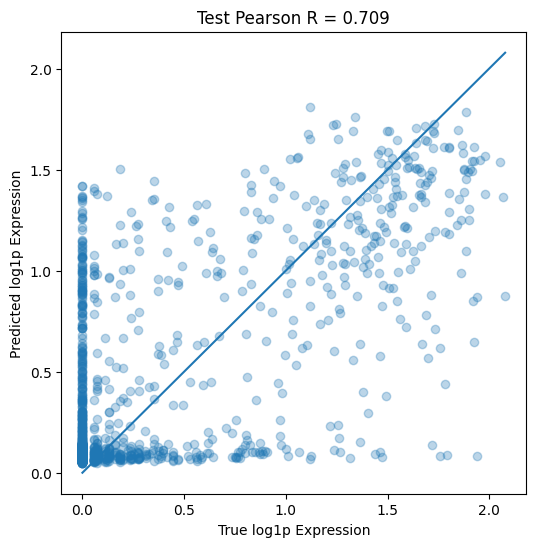

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(
    test_trues.flatten(), 
    test_preds.flatten(), 
    alpha=0.3
)
plt.xlabel("True log1p Expression")
plt.ylabel("Predicted log1p Expression")
plt.title(f"Test Pearson R = {test_pearson:.3f}")
plt.plot(
    [test_trues.min(), test_trues.max()],
    [test_trues.min(), test_trues.max()],
    color="red"
)
plt.show()

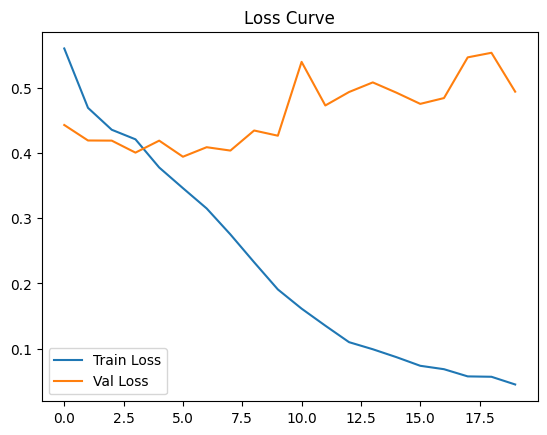

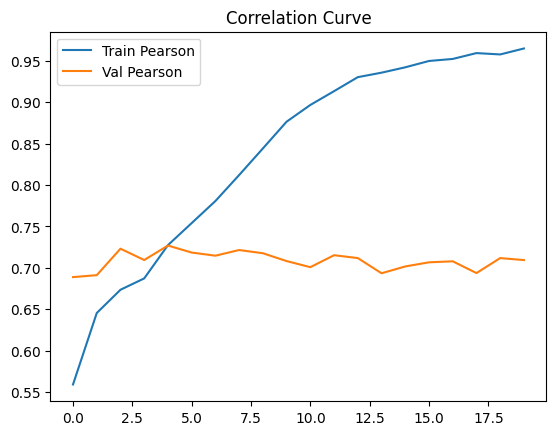

In [78]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_corrs, label="Train Pearson")
plt.plot(val_corrs, label="Val Pearson")
plt.legend()
plt.title("Correlation Curve")
plt.show()

/var/folders/ln/0t9fc__n27lf_tzsnl8rx0840000gn/T/ipykernel_90620/3245478033.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_enform

Replicates Direct Pearson R: -0.0301
Replicates Estimated (model) Pearson R: 0.7090


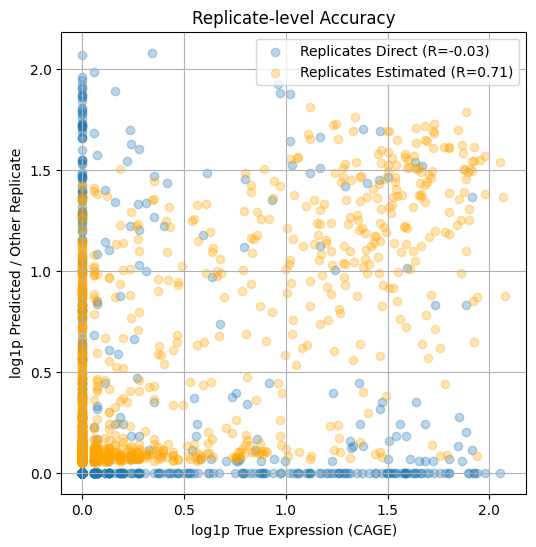

In [ ]:
sample_idx = 0  # you can loop over a few samples
true_signal = test_trues[sample_idx]   # shape: (num_bins,)
pred_signal = test_preds[sample_idx]   # shape: (num_bins,)

plt.figure(figsize=(12,4))
plt.plot(true_signal, label="True signal", color='blue')
plt.plot(pred_signal, label="Predicted signal", color='orange')
plt.xlabel("Bin")
plt.ylabel("log1p Signal")
plt.title(f"Sample {sample_idx} Signal Comparison")
plt.legend()
plt.show()